<a href="https://colab.research.google.com/github/Lubricy/notebooks/blob/master/volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.version.VERSION)
print(tf.test.gpu_device_name())

TensorFlow 2.x selected.
2.1.0
/device:GPU:0


In [0]:
import seaborn as sns 

In [0]:
import matplotlib as mpl
from datetime import timedelta
mpl.rcParams['figure.figsize'] = [16.0, 12.0]
mpl.rcParams['lines.linewidth'] = 1.0

In [4]:
import urllib
coin = 'BTC'
with urllib.request.urlopen(f"http://www.cryptodatadownload.com/cdd/Coinbase_{coin}USD_1h.csv") as f:
    print(next(f))
    data = pd.read_csv(f)
data['Date']= pd.to_datetime(data['Date'], format='%Y-%m-%d %I-%p')

b'Timestamps are UTC timezone,https://www.CryptoDataDownload.com\r\n'


In [0]:
data.index=data['Date']

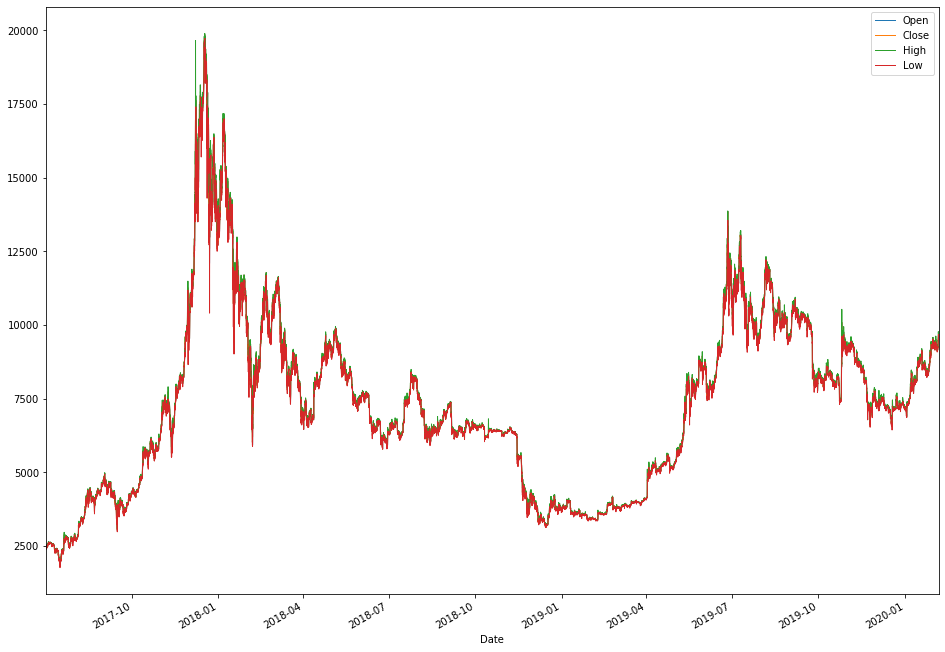

In [6]:
data[['Open', 'Close', 'High', 'Low']].plot()


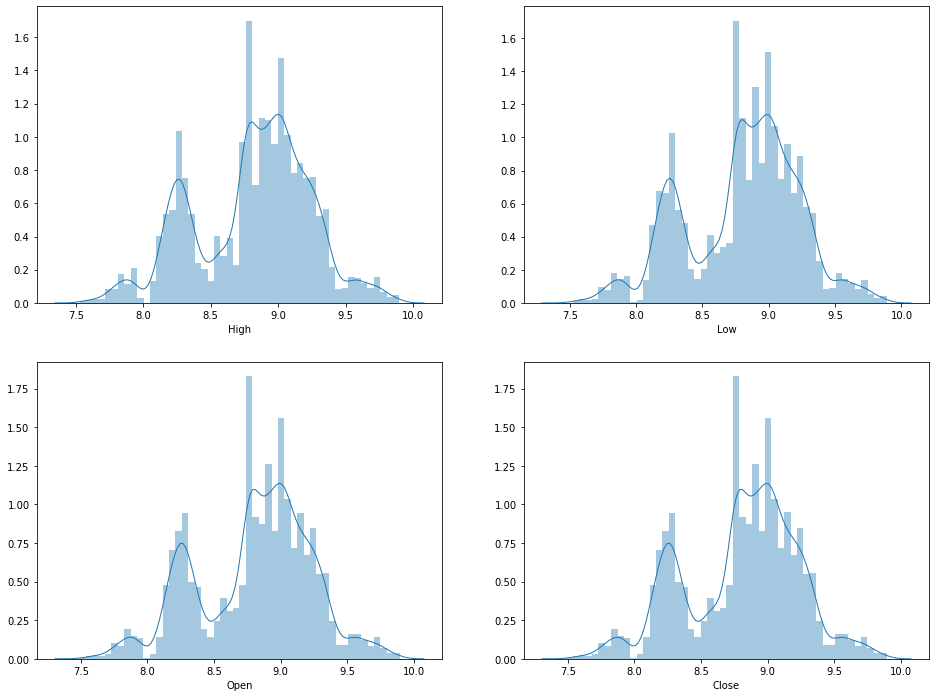

In [7]:
for i, d in enumerate(['High', 'Low', 'Open', 'Close'],1):
  plt.subplot(2,2,i)
  sns.distplot(np.log(data[d]))


In [0]:
modes = ['Open-Open', 'Close-Close', 'High-Low', 'Low-High']
windows = [3,6,12] + [days * 24 
                      for days 
                      in [1,7,30, 90, 180]] # day, week, month, quarter, half-year

In [0]:
def calculate_return_volatility(data, pv_fv=modes, windows = windows):
  for mode in pv_fv:
    pv, fv = mode.split('-')
    log_pv = np.log(data[pv].to_numpy())
    log_fv = np.log(data[fv].to_numpy())
    for window in windows:
      log_return = (log_fv[:-window] - log_pv[window:])
      data.loc[:, f'LogReturn_{mode}_{window}'] = np.append(log_return, [0]*window)
      volatility = np.std(np.vstack([data[f'LogReturn_{mode}_{window}'].to_numpy()[i:i-window] for i in range(window)]), axis=0) / window
      data.loc[:, f'volatility_{mode}_{window}'] = np.append(volatility, [0]*window)

In [0]:
calculate_return_volatility(data)

In [0]:
def plot_data(name, data, pv_fv=modes, windows = windows, bars=[1]):
  plots = len(pv_fv)
  linestyles = ['-','--', ':']
  fig, axs = plt.subplots(plots, 1, sharex=True)
  for index, mode in enumerate(pv_fv):
    for wid, window in enumerate(windows):
      data[f'{name}_{mode}_{window}'].plot(ax=axs[index])
      for bar in bars:
        axs[index].axvline(x=data.index[-1] + timedelta(hours=window * bar), ls=linestyles[bar], color=f'C{wid}')
    axs[index].axhline(color='k')
    axs[index].legend(loc='center left', bbox_to_anchor=(1, 0.5))
  fig.show()

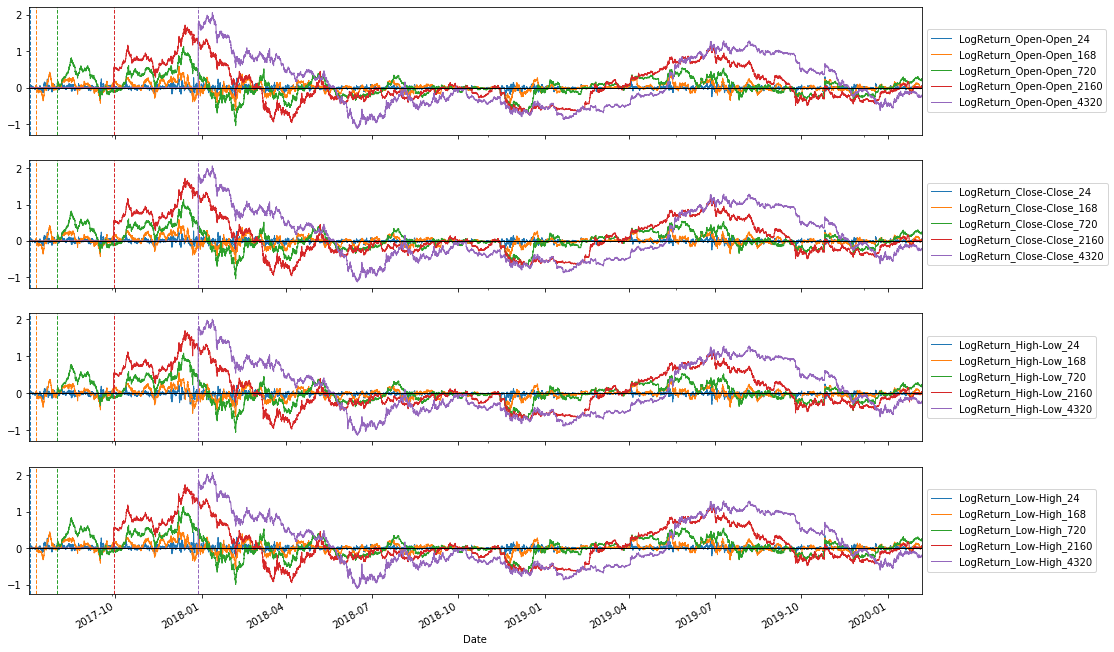

In [12]:
plot_data('LogReturn', data, windows=windows[3:])

In [0]:
def slice(start=None, end=None):
  start = pd.to_datetime(start)
  end = pd.to_datetime(end)
  def _slice(df):
    return df[(df.index >= start) & (df.index < end)].copy()
  return _slice

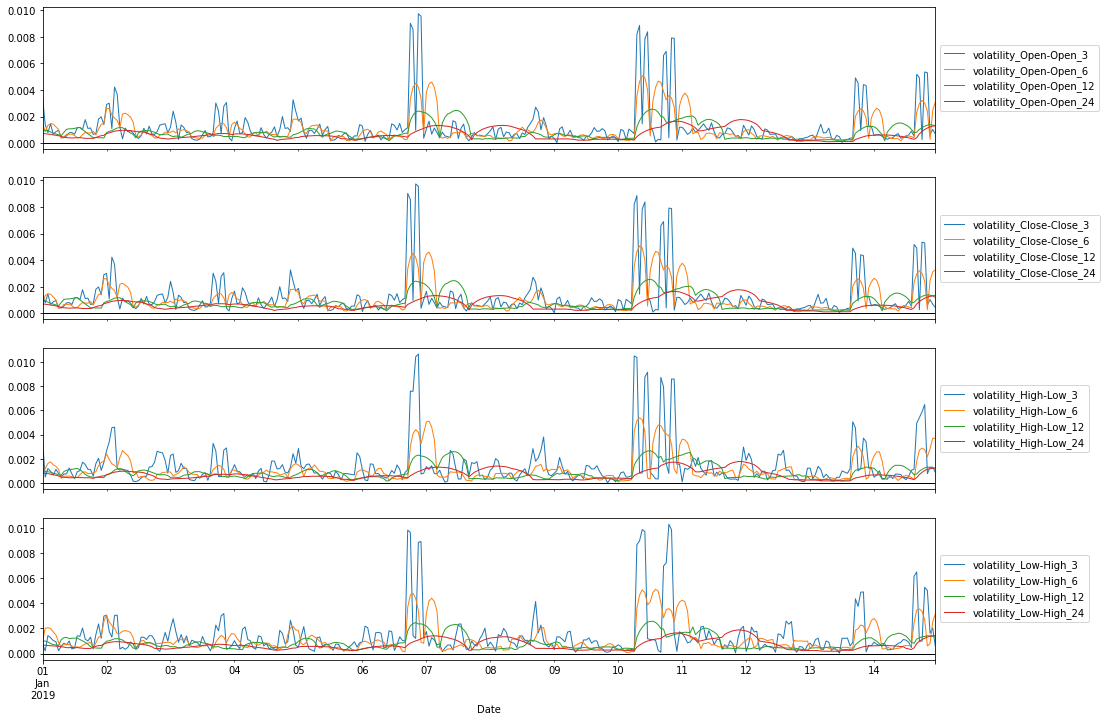

In [14]:
start_date = '2019-01-01' #@param {type:"date"}
end_date = '2019-01-15' #@param {type:"date"}
zoom = slice(start_date, end_date)
plot_data('volatility', zoom(data), bars=[], windows=windows[:4])

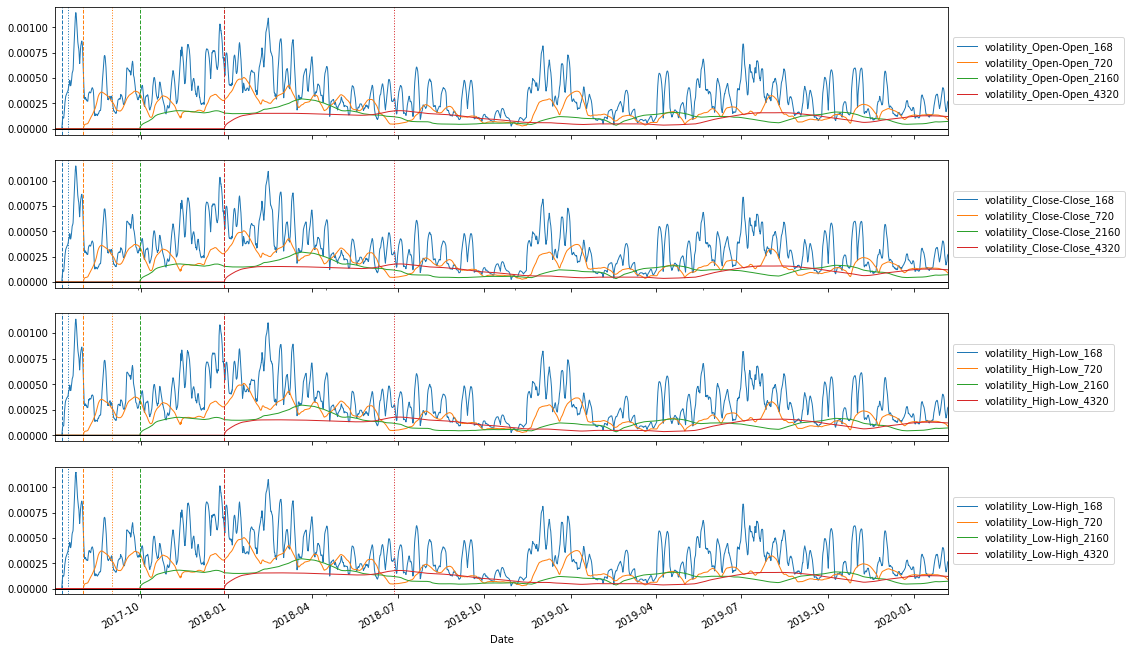

In [15]:
plot_data('volatility', data, bars=[1,2], windows=windows[4:])

In [0]:
def plot_diff(name, data, pv_fv=modes, windows = windows, bars=[1]):
  plots = len(windows)
  fig, axs = plt.subplots(plots, 1, sharex=True)
  for index, window in enumerate(windows):
    for mode in pv_fv:
      data[f'{name}_{mode}_{window}'].plot(ax = axs[index])
    for bar in bars:
      axs[index].axvline(x=data.index[-1] + timedelta(hours=window * bar), ls='--')
    axs[index].axhline(color='k')
    axs[index].legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

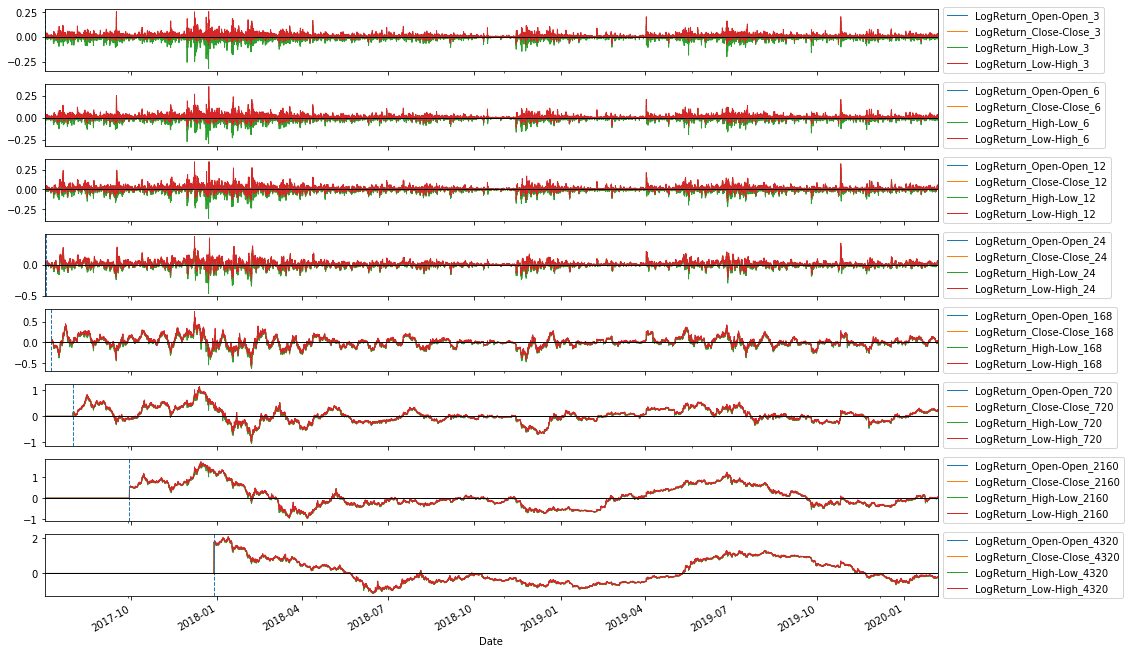

In [17]:
plot_diff('LogReturn', data)

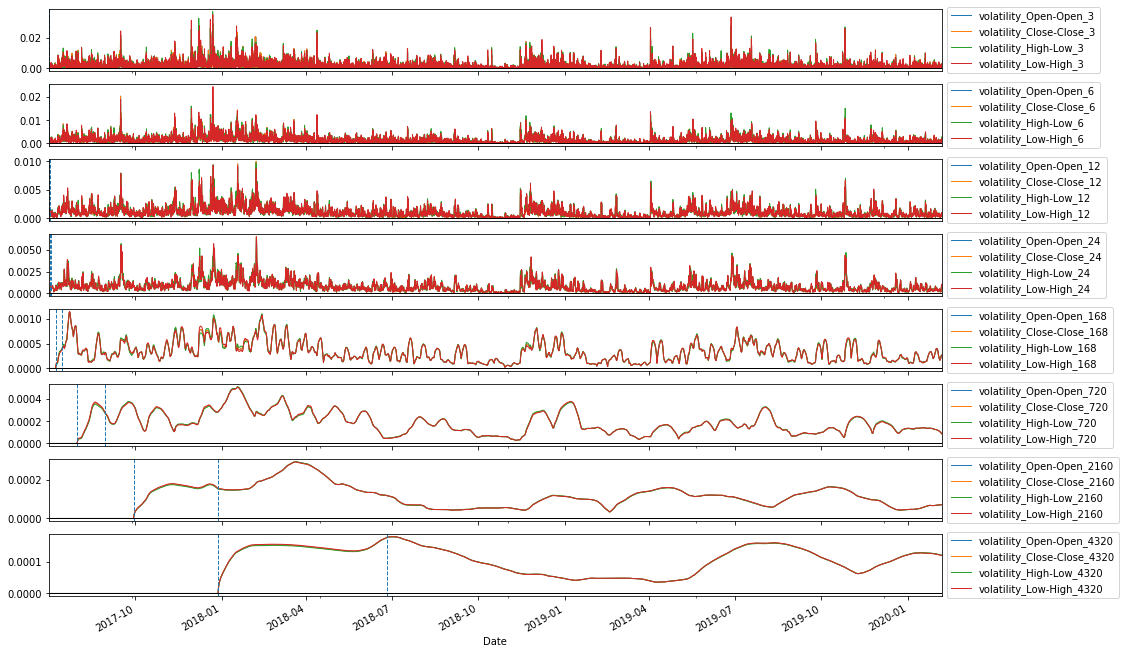

In [18]:
plot_diff('volatility', data, bars=[1,2])

In [0]:
def plot_hist(data, windows=windows):
  fig, axs = plt.subplots(len(windows), 2, sharex=True)
  for widx, window in enumerate(windows):
    for idx, plot in enumerate(['LogReturn', 'volatility']):
      for mode in modes:
        sns.distplot(data[f'{plot}_{mode}_{window}'].iloc[:-window], 
                    ax=axs[widx][idx],
                    label=mode)
        axs[widx][idx].legend(loc='center right') 
  plt.show()

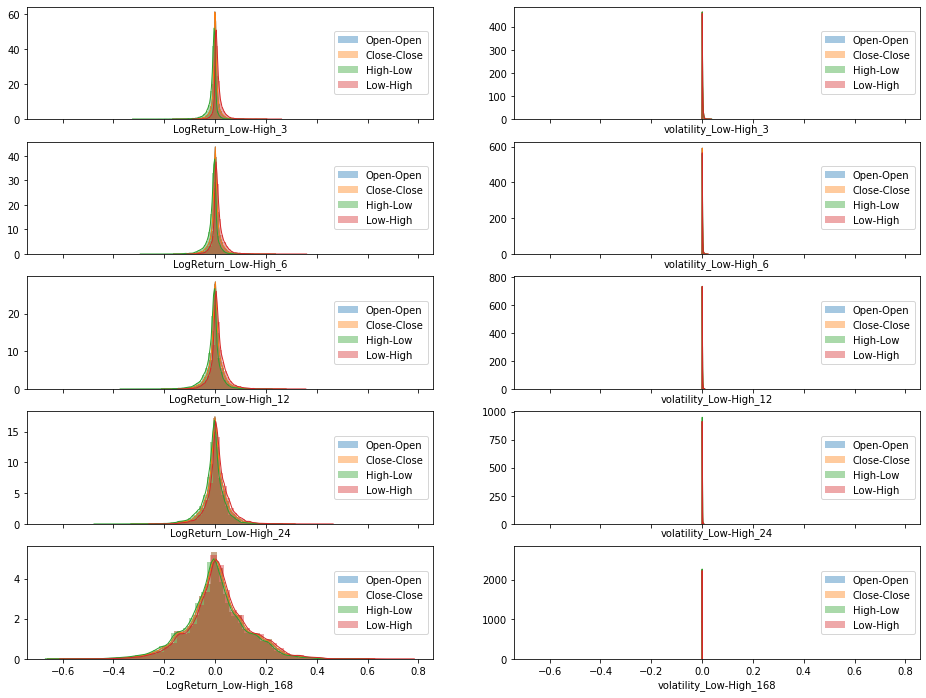

In [20]:
plot_hist(data, windows=windows[:5])

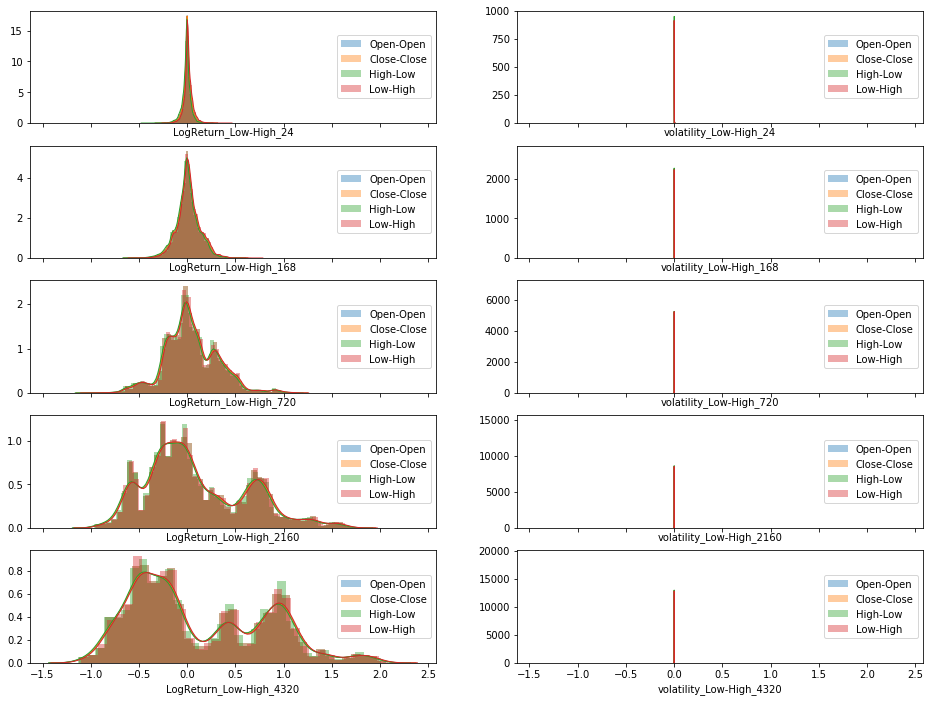

In [21]:
plot_hist(data, windows=windows[3:])